# LAPORAN PRAKTIKUM MODUL 3: WAVELET ANALYSIS

## PRAKTIKUM ANDAT II 2017

##### Kelompok 2: 
##### Resty Riany Muslim 12814005
##### Anugrah Noer Hadi 12814023
##### Prana Kesuma Suseno 12814025
##### Nurhayuni Dwi Arini 12814028
##### Hana Camelia 12814035

#### I. Tujuan
1. Menganalisis variabilitas curah hujan berdasarkan data curah hujan bulanan di kota Jakarta dan Ambon dengan metode wavelet analysis.
2. Menganalisis penyebab munculnya sinyal kuat pada data curah hujan kota Jakarta dan Ambon.
3. Menganalisis pengaruh penggunaan tipe wavelet yang berbeda terhadap analisis variabilitas curah hujan.

#### II. Data dan Script yang Digunakan
a. Data

Data yang digunakan merupakan data curah hujan bulanan GPCC tahun 1901-2013 kota Jakarta dan Ambon.

b. Script yang digunakan adalah sebagai berikut:

## JAKARTA

#### Membuka modules

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from wavelet import wavelet
from wave_signif import wave_signif

#### Membuka data

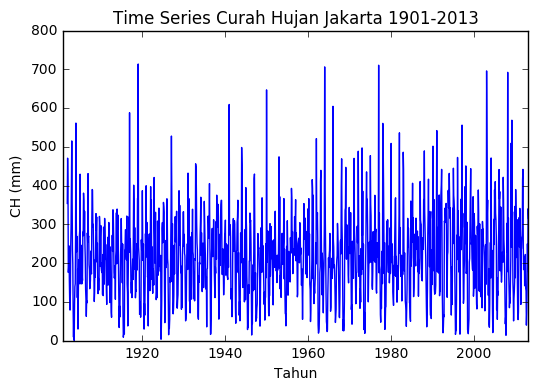

In [5]:
jkt=np.fromfile("jakarta.dat", dtype=np.float32)
chjkt = jkt
n=len(jkt)
dt = 1/12 

time = np.arange(n)*dt + 1902.0   # construct time array
xlim = [1901,2013]  # plotting range

plt.plot(time,jkt)
plt.xlabel('Tahun')
plt.ylabel('CH (mm)')
plt.title('Time Series Curah Hujan Jakarta 1901-2013')
xrange=plt.xlim(xlim)

#### Normalisasi data

In [6]:
variance = np.std(jkt)**2
mean=np.mean(jkt)
jkt = (jkt - np.mean(jkt))/np.sqrt(variance)
print ("mean=",mean)
print ("std=", np.sqrt(variance))

mean= 217.87
std= 110.91607666


#### Pengaturan parameter wavelet

In [7]:
pad = 1           # pad the time series with zeroes (recommended)
dj = 0.25         # this will do 4 sub-octaves per octave
s0 = 2.*dt        # this says start at a scale of 6 months
j1 = 7./dj        # this says do 7 powers-of-two with dj sub-octaves each
lag1 = 0.72       # lag-1 autocorrelation for red noise background
mother = 'MORLET' # wavelet shape (Morlet, Difference of Gaussian (DOG), Paul)

#### Transformasi wavelet

In [8]:
wave,period,scale,coi = wavelet(jkt,dt,pad,dj,s0,j1,mother);
power = (np.abs(wave))**2         # compute wavelet power spectrum

C:\Users\user\Documents\Modul 3 andat\wavelet.py:118: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  temp=np.zeros((2**(base2+1)-n1,))


#### Pengaturan selang kepercayaan

In [9]:
signif,fft_theor = wave_signif(1.0,dt,scale,0,lag1,-1,-1,mother)
sig95 = np.dot(signif.reshape(len(signif),1),np.ones((1,n))) # expand signif --> (J+1)x(N) array
sig95 = power / sig95         # where ratio > 1, power is significant

#### Spektrum global wavelet dan selang kepercayaan

In [10]:
global_ws = variance*power.sum(axis=1)/float(n)   # time-average over all times
dof = n - scale  # the -scale corrects for padding at edges
global_signif,fft_theor = wave_signif(variance,dt,scale,1,lag1,-1,dof,mother)

#### Scale-average pada rentang periode 

In [11]:
avg = (scale >=0.5) & (scale < 1.5)
Cdelta = 0.776;   # this is for the MORLET wavelet
scale_avg = np.dot(scale.reshape(len(scale),1),np.ones((1,n))) # expand scale --> (J+1)x(N) array
scale_avg = power / scale_avg   # [Eqn(24)]
scale_avg = variance*dj*dt/Cdelta*sum(scale_avg[avg,:])   # [Eqn(24)]
scaleavg_signif ,fft_theor= wave_signif(variance,dt,scale,2,lag1,-1,[2,7.9],mother)

#### Penyusunan kembali time series

In [12]:
from wavelet_inverse import wavelet_inverse
iwave=wavelet_inverse(wave, scale, dt, dj, "Morlet")
print ("RMSE:",np.sqrt(np.sum((jkt-iwave)**2)/float(len(jkt)))*np.sqrt(variance))

RMSE: 12.3098345289


#### Plot (biased)

#### Pengkoreksian Bias

C:\Users\user\Anaconda3\lib\site-packages\ipykernel\__main__.py:36: RuntimeWarning: divide by zero encountered in log2


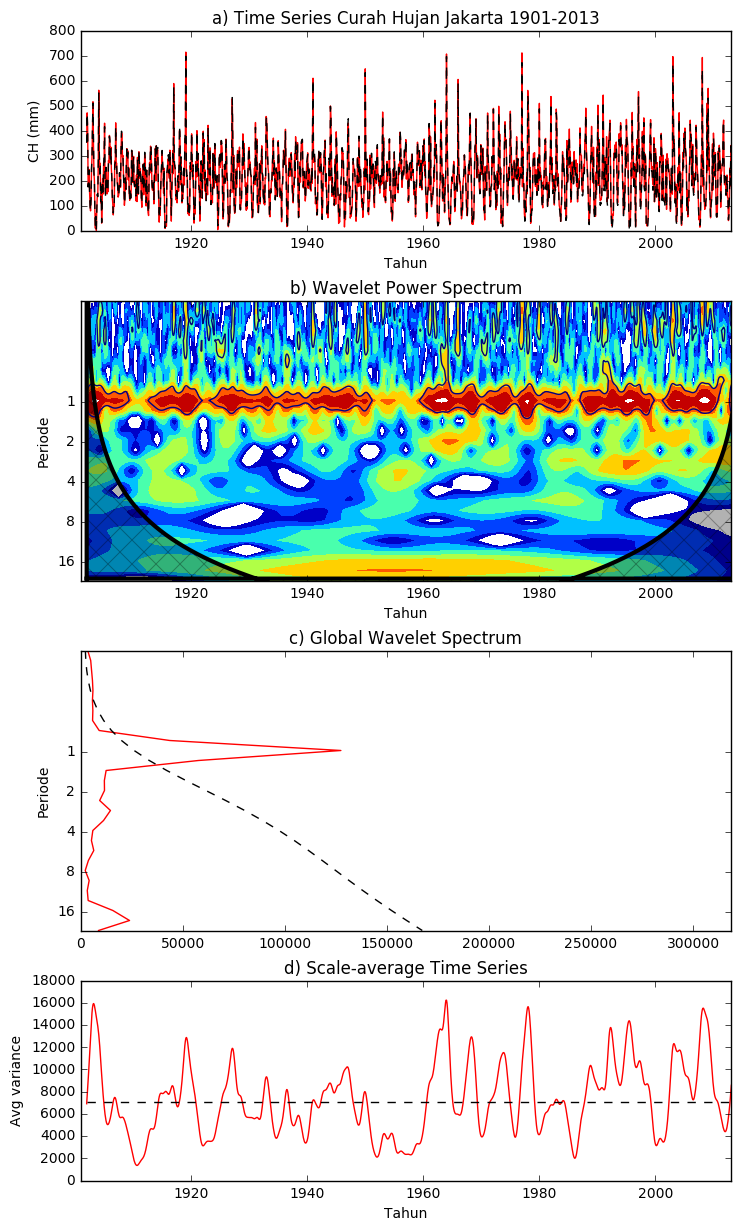

In [13]:
#figure size
fig=plt.figure(figsize=(10,10))

# subplot positions
width= 0.65
hight = 0.28;
pos1a = [0.1, 0.75, width, 0.2]
pos1b = [0.1, 0.4, width, hight]
pos1c = [0.1, 0.05, width, hight]
pos1d = [0.1, -0.2, width, 0.2]

#########################################
#---- a) Original signal
#########################################
ax=fig.add_axes(pos1a)
#original
ax.plot(time,jkt*np.sqrt(variance)+mean,"r-")
#reconstruction
ax.plot(time,iwave*np.sqrt(variance)+mean,"k--")
ax.set_ylabel('CH (mm)')
ax.set_xlabel('Tahun')
plt.title('a) Time Series Curah Hujan Jakarta 1901-2013')

#########################################
#   b) Wavelet spectrum
#########################################

#--- Contour plot wavelet power spectrum
bx=fig.add_axes(pos1b,sharex=ax)
levels = [0.0625,0.125,0.25,0.5,1,2,4,8,16] 
Yticks = 2**(np.arange(np.int(np.log2(np.min(period))),np.int(np.log2(np.max(period)))+1))
bx.contourf(time,np.log2(period),np.log2(power),np.log2(levels))
bx.set_xlabel('Tahun')
bx.set_ylabel('Periode')
import matplotlib.ticker as ticker
ymajorLocator=ticker.FixedLocator(np.log2(Yticks))
bx.yaxis.set_major_locator( ymajorLocator )
ticks=bx.yaxis.set_ticklabels(Yticks)
plt.title('b) Wavelet Power Spectrum')

# 95% significance contour, levels at -99 (fake) and 1 (95% signif)
cs = bx.contour(time,np.log2(period),sig95,[1],color='k',linewidth=1)

# cone-of-influence, anything "below" is dubious
ts = time;
coi_area = np.concatenate([[np.max(scale)], coi, [np.max(scale)],[np.max(scale)]])
ts_area = np.concatenate([[ts[0]], ts, [ts[-1]] ,[ts[0]]]);
L = bx.plot(ts_area,np.log2(coi_area),'k',linewidth=3)
F=bx.fill(ts_area,np.log2(coi_area),'k',alpha=0.3,hatch="x")

#########################################
#   c) Global Wavelet spectrum
#########################################

#--- Plot global wavelet spectrum
cx=fig.add_axes(pos1c,sharey=bx)
cx.plot(global_ws,np.log2(period),"r-")
cx.plot(global_signif,np.log2(period),'k--')
ylim=cx.set_ylim(np.log2([period.min(),period.max()]))
cx.invert_yaxis()
plt.title('c) Global Wavelet Spectrum')
xrangec=cx.set_xlim([0,1.25*2*np.max(global_ws)])
cx.set_ylabel('Periode')

#########################################
#   d) Scale average Spectrum
#########################################
#--- Plot Scale-averaged spectrum -----------------
dx=fig.add_axes(pos1d,sharex=bx)
dx.plot(time,scale_avg,"r-")
dx.plot([time[0],time[-1]],[scaleavg_signif,scaleavg_signif],"k--")
xrange=dx.set_xlim(xlim)
dx.set_ylabel('Avg variance')
dx.set_xlabel('Tahun')
title=plt.title('d) Scale-average Time Series')

In [14]:
########################
#  Spectrum
########################
powers=np.zeros_like(power)
for k in range(len(scale)):
    powers[k,:] = power[k,:]/scale[k]
#significance: sig95 is already normalized = 1

########################
#  Spectrum
########################
global_wss = global_ws/scale   
global_signifs=global_signif/scale

########################
#  Scale-average between El Nino periods of 2--8 years
########################
# No need to change 
# because in Eqn(24) of Torrence and Compo [1998], division by scale has been done.
scale_avgs=scale_avg
scaleavg_signifs=scaleavg_signif

#### Plot (nonbiased)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel\__main__.py:37: RuntimeWarning: divide by zero encountered in log2


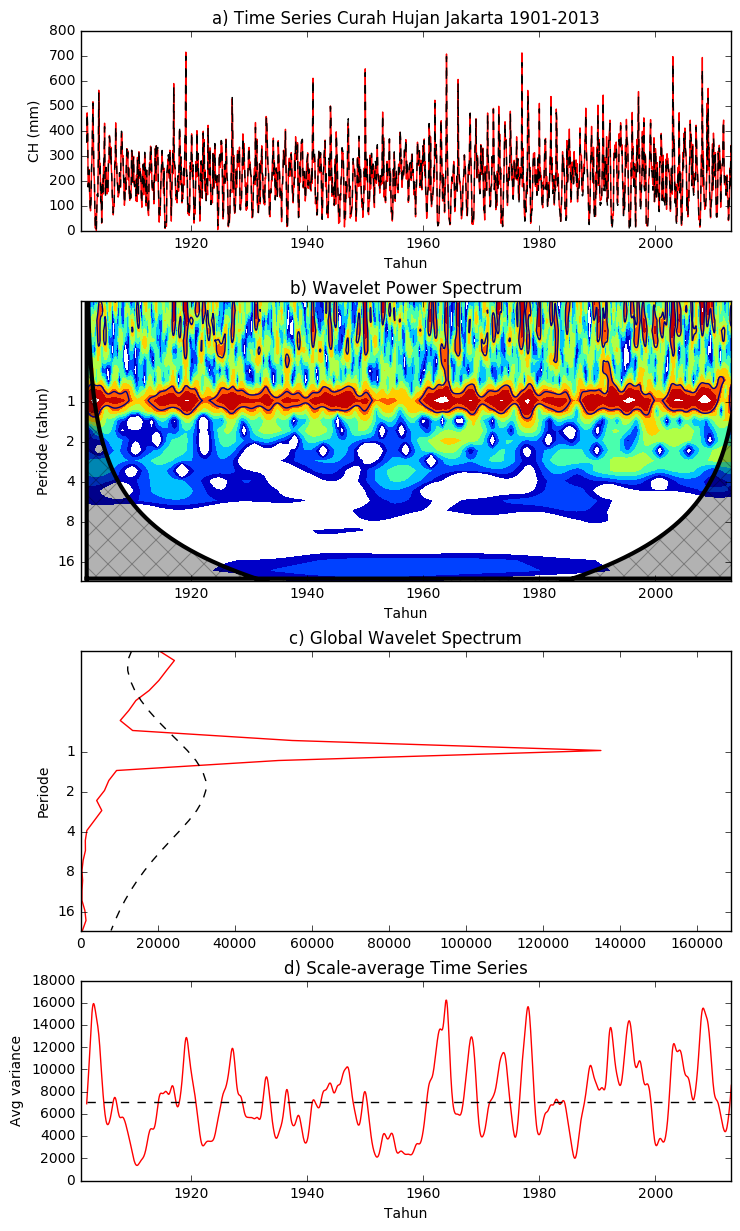

In [15]:
#figure size
fig=plt.figure(figsize=(10,10))

# subplot positions
width= 0.65
hight = 0.28;
pos1a = [0.1, 0.75, width, 0.2]
pos1b = [0.1, 0.4, width, hight]
pos1c = [0.1, 0.05, width, hight]
pos1d = [0.1, -0.2, width, 0.2]

#########################################
#---- a) Original signal
#########################################
ax=fig.add_axes(pos1a)
#original
ax.plot(time,jkt*np.sqrt(variance)+mean,"r-")
#reconstruction
ax.plot(time,iwave*np.sqrt(variance)+mean,"k--")

ax.set_ylabel('CH (mm)')
ax.set_xlabel('Tahun')
plt.title('a) Time Series Curah Hujan Jakarta 1901-2013')

#########################################
#   b) Wavelet spectrum
#########################################

#--- Contour plot wavelet power spectrum
bx=fig.add_axes(pos1b,sharex=ax)
levels = [0.0625,0.125,0.25,0.5,1,2,4,8,16] 
Yticks = 2**(np.arange(np.int(np.log2(np.min(period))),np.int(np.log2(np.max(period)))+1))
bx.contourf(time,np.log2(period),np.log2(powers),np.log2(levels))
bx.set_xlabel('Tahun')
bx.set_ylabel('Periode (tahun)')
import matplotlib.ticker as ticker
ymajorLocator=ticker.FixedLocator(np.log2(Yticks))
bx.yaxis.set_major_locator( ymajorLocator )
ticks=bx.yaxis.set_ticklabels(Yticks)
plt.title('b) Wavelet Power Spectrum')

# 95% significance contour, levels at -99 (fake) and 1 (95% signif)
cs = bx.contour(time,np.log2(period),sig95,[1],color='w',linewidth=1)

# cone-of-influence, anything "below" is dubious
ts = time;
coi_area = np.concatenate([[np.max(scale)], coi, [np.max(scale)],[np.max(scale)]])
ts_area = np.concatenate([[ts[0]], ts, [ts[-1]] ,[ts[0]]]);
L = bx.plot(ts_area,np.log2(coi_area),'k',linewidth=3)
F=bx.fill(ts_area,np.log2(coi_area),'k',alpha=0.3,hatch="x")

#########################################
#   c) Global Wavelet spectrum
#########################################

#--- Plot global wavelet spectrum
cx=fig.add_axes(pos1c,sharey=bx)
cx.plot(global_wss,np.log2(period),"r-")
cx.plot(global_signifs,np.log2(period),'k--')
ylim=cx.set_ylim(np.log2([period.min(),period.max()]))
cx.invert_yaxis()
plt.title('c) Global Wavelet Spectrum')
xrangec=cx.set_xlim([0,1.25*np.max(global_wss)])
cx.set_ylabel('Periode')

#########################################
#   d) Global Wavelet spectrum
#########################################
#--- Plot Scale-averaged spectrum -----------------
dx=fig.add_axes(pos1d,sharex=bx)
dx.plot(time,scale_avgs,"r-")
dx.plot([time[0],time[-1]],[scaleavg_signifs,scaleavg_signifs],"k--")
xrange=dx.set_xlim(xlim)
dx.set_ylabel('Avg variance')
dx.set_xlabel('Tahun')
title=plt.title('d) Scale-average Time Series')

Analisis:
Hasil plot time series curah hujan di Jakarta secara umum menunjukkan fluktuasi yang besar sehingga dipilihlah tipe wavelet Morlet. Dari hasil plot diatas dapat dilihat bahwa di Jakarta memiliki pengaruh besar dalam periode 1 tahunan, fenomena ini merupakan monsun. 


## AMBON

#### Membuka modules

In [50]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from wavelet import wavelet
from wave_signif import wave_signif

#### Membaca data

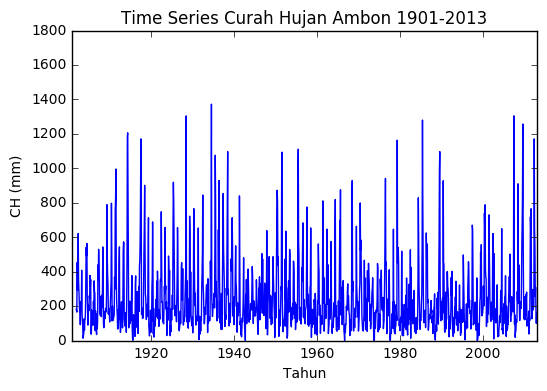

In [51]:
ambon=np.fromfile("ambon.dat", dtype=np.float32)
chambon = ambon
n=len(ambon)
dt = 1/12 

time = np.arange(n)*dt + 1902.0   # construct time array
xlim = [1901,2013]  # plotting range

plt.plot(time,ambon)
xrange=plt.xlim(xlim)
plt.ylabel('CH (mm)')
plt.xlabel('Tahun')
plt.title('Time Series Curah Hujan Ambon 1901-2013')

#### Normalisasi data

In [52]:
variance = np.std(ambon)**2
mean=np.mean(ambon)
ambon = (ambon - np.mean(ambon))/np.sqrt(variance)
print ("mean=",mean)
print ("std=", np.sqrt(variance))

mean= 245.683
std= 213.313552856


#### Pengaturan parameter wavelet

In [53]:
pad = 1           # pad the time series with zeroes (recommended)
dj = 0.25         # this will do 4 sub-octaves per octave
s0 = 2.*dt        # this says start at a scale of 6 months
j1 = 7./dj        # this says do 7 powers-of-two with dj sub-octaves each
lag1 = 0.72       # lag-1 autocorrelation for red noise background
mother = 'MORLET' # wavelet shape (Morlet, Difference of Gaussian (DOG), Paul)

#### Transformasi wavelet

In [54]:
wave,period,scale,coi = wavelet(ambon,dt,pad,dj,s0,j1,mother);
power = (np.abs(wave))**2         # compute wavelet power spectrum

C:\Users\user\Documents\Modul 3 andat\wavelet.py:118: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  temp=np.zeros((2**(base2+1)-n1,))


#### Pengaturan selang kepercayaan

In [55]:
signif,fft_theor = wave_signif(1.0,dt,scale,0,lag1,-1,-1,mother)
sig95 = np.dot(signif.reshape(len(signif),1),np.ones((1,n))) # expand signif --> (J+1)x(N) array
sig95 = power / sig95         # where ratio > 1, power is significant

#### Spektrum global wavelet dan selang kepercayaan

In [56]:
global_ws = variance*power.sum(axis=1)/float(n)   # time-average over all times
dof = n - scale  # the -scale corrects for padding at edges
global_signif,fft_theor = wave_signif(variance,dt,scale,1,lag1,-1,dof,mother)

#### Scale-average pada periode 1 dan 4

In [57]:
avg = (scale >= 0.5) & (scale < 1.5)
Cdelta = 0.776;   # this is for the MORLET wavelet
scale_avg = np.dot(scale.reshape(len(scale),1),np.ones((1,n))) # expand scale --> (J+1)x(N) array
scale_avg = power / scale_avg   # [Eqn(24)]
scale_avg = variance*dj*dt/Cdelta*sum(scale_avg[avg,:])   # [Eqn(24)]
scaleavg_signif ,fft_theor= wave_signif(variance,dt,scale,2,lag1,-1,[2,7.9],mother)

#### Penyusunan kembali time series

In [58]:
from wavelet_inverse import wavelet_inverse
iwave=wavelet_inverse(wave, scale, dt, dj, "Morlet")
print ("RMSE:",np.sqrt(np.sum((ambon-iwave)**2)/float(len(ambon)))*np.sqrt(variance))

RMSE: 28.0547544221


#### Plot (biased)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel\__main__.py:38: RuntimeWarning: divide by zero encountered in log2


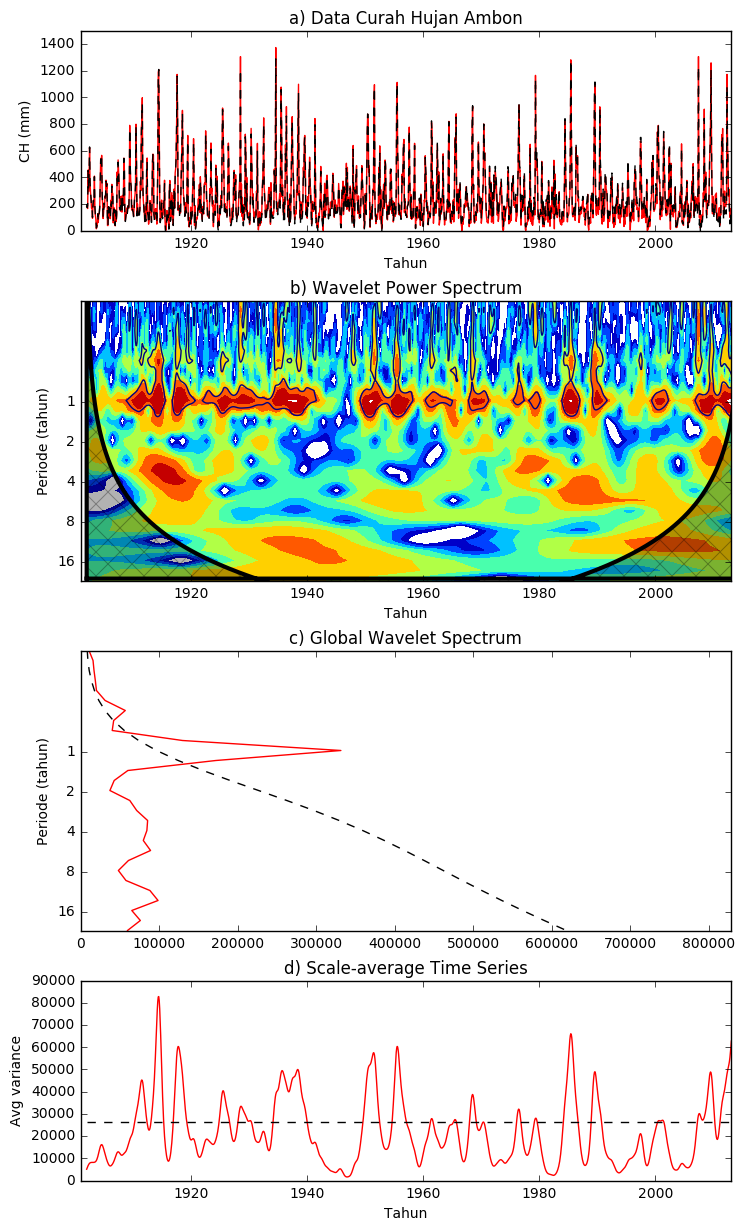

In [59]:
#figure size
fig=plt.figure(figsize=(10,10))

# subplot positions
width= 0.65
hight = 0.28;
pos1a = [0.1, 0.75, width, 0.2]
pos1b = [0.1, 0.4, width, hight]
pos1c = [0.1, 0.05, width, hight]
pos1d = [0.1, -0.2, width, 0.2]

#########################################
#---- a) Original signal
#########################################
ax=fig.add_axes(pos1a)
#original
ax.plot(time,ambon*np.sqrt(variance)+mean,"r-")
#reconstruction
ax.plot(time,iwave*np.sqrt(variance)+mean,"k--")

ax.set_ylabel('CH (mm)')
ax.set_xlabel('Tahun')
plt.title('a) Data Curah Hujan Ambon')
ax.set_ylim([0,1500])

#########################################
#   b) Wavelet spectrum
#########################################

#--- Contour plot wavelet power spectrum
bx=fig.add_axes(pos1b,sharex=ax)
levels = [0.0625,0.125,0.25,0.5,1,2,4,8,16] 
Yticks = 2**(np.arange(np.int(np.log2(np.min(period))),np.int(np.log2(np.max(period)))+1))
bx.contourf(time,np.log2(period),np.log2(power),np.log2(levels))
bx.set_xlabel('Tahun')
bx.set_ylabel('Periode (tahun)')
import matplotlib.ticker as ticker
ymajorLocator=ticker.FixedLocator(np.log2(Yticks))
bx.yaxis.set_major_locator( ymajorLocator )
ticks=bx.yaxis.set_ticklabels(Yticks)
plt.title('b) Wavelet Power Spectrum')

# 95% significance contour, levels at -99 (fake) and 1 (95% signif)
cs = bx.contour(time,np.log2(period),sig95,[1],color='k',linewidth=1)

# cone-of-influence, anything "below" is dubious
ts = time;
coi_area = np.concatenate([[np.max(scale)], coi, [np.max(scale)],[np.max(scale)]])
ts_area = np.concatenate([[ts[0]], ts, [ts[-1]] ,[ts[0]]]);
L = bx.plot(ts_area,np.log2(coi_area),'k',linewidth=3)
F=bx.fill(ts_area,np.log2(coi_area),'k',alpha=0.3,hatch="x")

#########################################
#   c) Global Wavelet spectrum
#########################################

#--- Plot global wavelet spectrum
cx=fig.add_axes(pos1c,sharey=bx)
cx.plot(global_ws,np.log2(period),"r-")
cx.plot(global_signif,np.log2(period),'k--')
ylim=cx.set_ylim(np.log2([period.min(),period.max()]))
cx.invert_yaxis()
plt.title('c) Global Wavelet Spectrum')
xrangec=cx.set_xlim([0,1.25*2*np.max(global_ws)])
cx.set_ylabel('Periode (tahun)')

#########################################
#   d) Scale average Spectrum
#########################################
#--- Plot Scale-averaged spectrum -----------------
dx=fig.add_axes(pos1d,sharex=bx)
dx.plot(time,scale_avg,"r-")
dx.plot([time[0],time[-1]],[scaleavg_signif,scaleavg_signif],"k--")
xrange=dx.set_xlim(xlim)
dx.set_ylabel('Avg variance')
dx.set_xlabel('Tahun')
title=plt.title('d) Scale-average Time Series')

#### Pengoreksian Bias

In [60]:
########################
#  Spectrum
########################
powers=np.zeros_like(power)
for k in range(len(scale)):
    powers[k,:] = power[k,:]/scale[k]
#significance: sig95 is already normalized = 1

########################
#  Spectrum
########################
global_wss = global_ws/scale   
global_signifs=global_signif/scale

########################
#  Scale-average between El Nino periods of 2--8 years
########################
# No need to change 
# because in Eqn(24) of Torrence and Compo [1998], division by scale has been done.
scale_avgs=scale_avg
scaleavg_signifs=scaleavg_signif

#### Plot (nonbiased)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel\__main__.py:38: RuntimeWarning: divide by zero encountered in log2


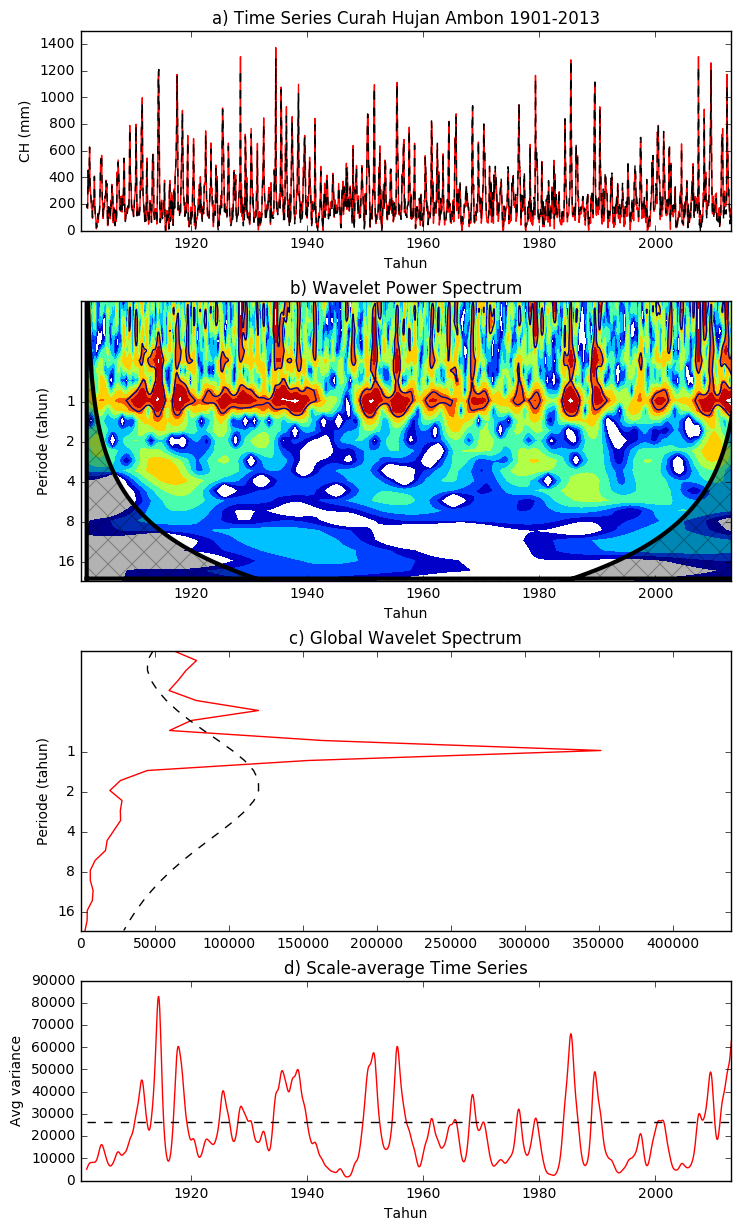

In [61]:
#figure size
fig=plt.figure(figsize=(10,10))

# subplot positions
width= 0.65
hight = 0.28;
pos1a = [0.1, 0.75, width, 0.2]
pos1b = [0.1, 0.4, width, hight]
pos1c = [0.1, 0.05, width, hight]
pos1d = [0.1, -0.2, width, 0.2]

#########################################
#---- a) Original signal
#########################################
ax=fig.add_axes(pos1a)
#original
ax.plot(time,ambon*np.sqrt(variance)+mean,"r-")
#reconstruction
ax.plot(time,iwave*np.sqrt(variance)+mean,"k--")

ax.set_ylabel('CH (mm)')
ax.set_xlabel('Tahun')
plt.title('a) Time Series Curah Hujan Ambon 1901-2013')
ax.set_ylim([0,1500])

#########################################
#   b) Wavelet spectrum
#########################################

#--- Contour plot wavelet power spectrum
bx=fig.add_axes(pos1b,sharex=ax)
levels = [0.0625,0.125,0.25,0.5,1,2,4,8,16] 
Yticks = 2**(np.arange(np.int(np.log2(np.min(period))),np.int(np.log2(np.max(period)))+1))
bx.contourf(time,np.log2(period),np.log2(powers),np.log2(levels))
bx.set_xlabel('Tahun')
bx.set_ylabel('Periode (tahun)')
import matplotlib.ticker as ticker
ymajorLocator=ticker.FixedLocator(np.log2(Yticks))
bx.yaxis.set_major_locator( ymajorLocator )
ticks=bx.yaxis.set_ticklabels(Yticks)
plt.title('b) Wavelet Power Spectrum')

# 95% significance contour, levels at -99 (fake) and 1 (95% signif)
cs = bx.contour(time,np.log2(period),sig95,[1],color='w',linewidth=1)

# cone-of-influence, anything "below" is dubious
ts = time;
coi_area = np.concatenate([[np.max(scale)], coi, [np.max(scale)],[np.max(scale)]])
ts_area = np.concatenate([[ts[0]], ts, [ts[-1]] ,[ts[0]]]);
L = bx.plot(ts_area,np.log2(coi_area),'k',linewidth=3)
F=bx.fill(ts_area,np.log2(coi_area),'k',alpha=0.3,hatch="x")

#########################################
#   c) Global Wavelet spectrum
#########################################

#--- Plot global wavelet spectrum
cx=fig.add_axes(pos1c,sharey=bx)
cx.plot(global_wss,np.log2(period),"r-")
cx.plot(global_signifs,np.log2(period),'k--')
ylim=cx.set_ylim(np.log2([period.min(),period.max()]))
cx.invert_yaxis()
plt.title('c) Global Wavelet Spectrum')
xrangec=cx.set_xlim([0,1.25*np.max(global_wss)])
cx.set_ylabel('Periode (tahun)')

#########################################
#   d) Global Wavelet spectrum
#########################################
#--- Plot Scale-averaged spectrum -----------------
dx=fig.add_axes(pos1d,sharex=bx)
dx.plot(time,scale_avgs,"r-")
dx.plot([time[0],time[-1]],[scaleavg_signifs,scaleavg_signifs],"k--")
xrange=dx.set_xlim(xlim)
dx.set_ylabel('Avg variance')
dx.set_xlabel('Tahun')
title=plt.title('d) Scale-average Time Series')

Analisis:
Hasil plot time series curah hujan di Ambon secara umum menunjukkan fluktuasi yang besar sehingga dipilihlah tipe wavelet Morlet. Dari hasil plot diatas dapat dilihat bahwa di Ambon walaupun terlihat lebih lemah dari Jakarta. Fenomena ini merupakan monsun. Salah satu penyebabnya karena memang monsun yang kita kenal merupakan javasentris. Di ambon pengaruh monsun di ambon makin menurun dari 1920 – 2000.


### WAVELET ANALYSIS DENGAN TIPE WAVELET YANG BERBEDA: JAKARTA (PAUL)

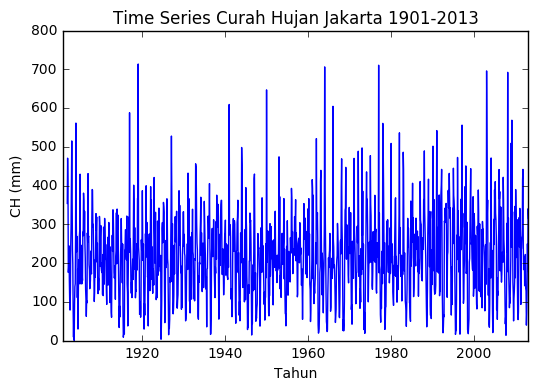

In [62]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from wavelet import wavelet
from wave_signif import wave_signif

jkt=np.fromfile("jakarta.dat", dtype=np.float32)
chjkt = jkt
n=len(jkt)
dt = 1/12

time = np.arange(n)*dt + 1902.0   # construct time array
xlim = [1901,2013]  # plotting range

plt.plot(time,jkt)
plt.xlabel('Tahun')
plt.ylabel('CH (mm)')
plt.title('Time Series Curah Hujan Jakarta 1901-2013')
xrange=plt.xlim(xlim)

In [63]:
variance = np.std(jkt)**2
mean=np.mean(jkt)
jkt = (jkt - np.mean(jkt))/np.sqrt(variance)
print ("mean=",mean)
print ("std=", np.sqrt(variance))

mean= 217.87
std= 110.91607666


In [64]:
pad = 1           # pad the time series with zeroes (recommended)
dj = 0.25         # this will do 4 sub-octaves per octave
s0 = 2.*dt        # this says start at a scale of 6 months
j1 = 7./dj        # this says do 7 powers-of-two with dj sub-octaves each
lag1 = 0.72       # lag-1 autocorrelation for red noise background
mother = 'Paul' # wavelet shape (Morlet, Difference of Gaussian (DOG), Paul)

In [65]:
#Transformasi wavelet
wave,period,scale,coi = wavelet(jkt,dt,pad,dj,s0,j1,mother);
power = (np.abs(wave))**2         # compute wavelet power spectrum

C:\Users\user\Documents\Modul 3 andat\wavelet.py:118: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  temp=np.zeros((2**(base2+1)-n1,))


In [66]:
#Pengaturan Selang Kepercayaan
signif,fft_theor = wave_signif(1.0,dt,scale,0,lag1,-1,-1,mother)
sig95 = np.dot(signif.reshape(len(signif),1),np.ones((1,n))) # expand signif --> (J+1)x(N) array
sig95 = power / sig95         # where ratio > 1, power is significant

In [67]:
#Spektrum Global Wavelet dan Selang Kepercayaan
global_ws = variance*power.sum(axis=1)/float(n)   # time-average over all times
dof = n - scale  # the -scale corrects for padding at edges
global_signif,fft_theor = wave_signif(variance,dt,scale,1,lag1,-1,dof,mother)

In [68]:
#Scale average pada rentang periode 2 dan 4
avg = (scale >= 0.5) & (scale < 1.5)
Cdelta = 1.132;   # this is for the MORLET wavelet
scale_avg = np.dot(scale.reshape(len(scale),1),np.ones((1,n))) # expand scale --> (J+1)x(N) array
scale_avg = power / scale_avg   # [Eqn(24)]
scale_avg = variance*dj*dt/Cdelta*sum(scale_avg[avg,:])   # [Eqn(24)]
scaleavg_signif ,fft_theor= wave_signif(variance,dt,scale,2,lag1,-1,[2,7.9],mother)

In [69]:
#Penyusunan kembali time series
from wavelet_inverse import wavelet_inverse
iwave=wavelet_inverse(wave, scale, dt, dj, "Paul")
print ("RMSE:",np.sqrt(np.sum((jkt-iwave)**2)/float(len(jkt)))*np.sqrt(variance))

RMSE: 33.2603152772


C:\Users\user\Anaconda3\lib\site-packages\ipykernel\__main__.py:36: RuntimeWarning: divide by zero encountered in log2


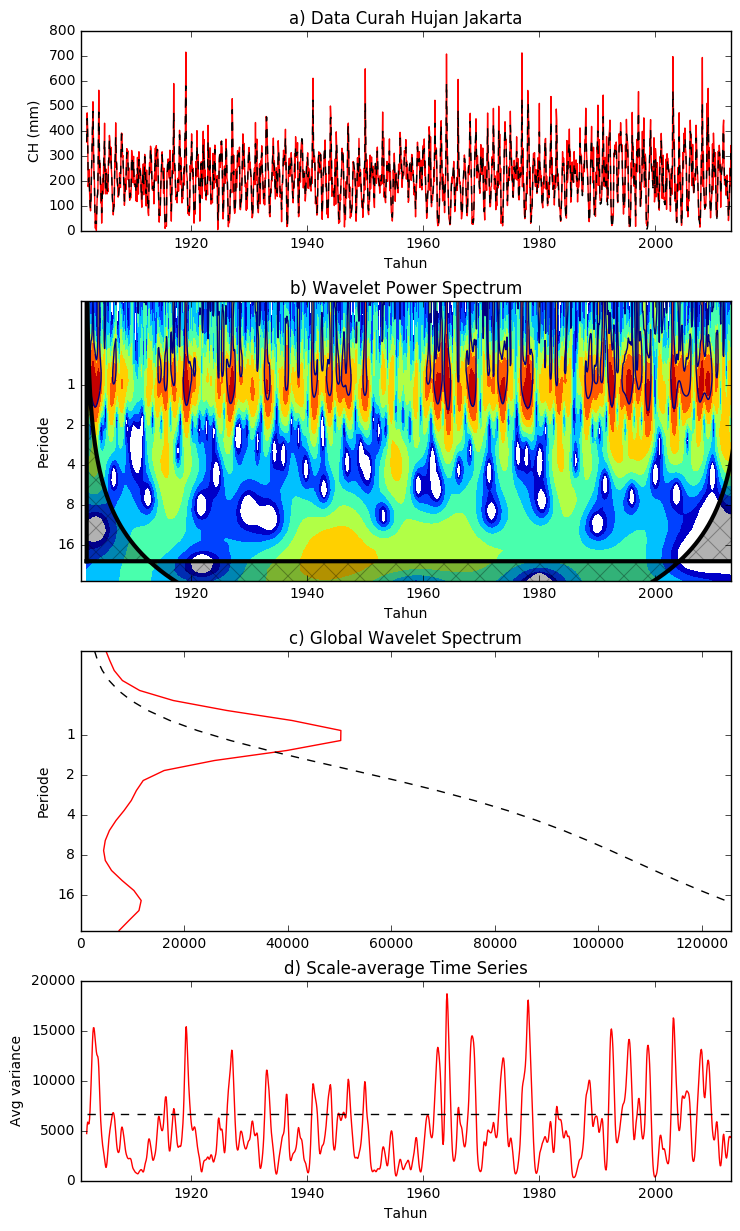

In [70]:
#figure size
fig=plt.figure(figsize=(10,10))

# subplot positions
width= 0.65
hight = 0.28;
pos1a = [0.1, 0.75, width, 0.2]
pos1b = [0.1, 0.4, width, hight]
pos1c = [0.1, 0.05, width, hight]
pos1d = [0.1, -0.2, width, 0.2]

#########################################
#---- a) Original signal
#########################################
ax=fig.add_axes(pos1a)
#original
ax.plot(time,jkt*np.sqrt(variance)+mean,"r-")
#reconstruction
ax.plot(time,iwave*np.sqrt(variance)+mean,"k--")
ax.set_ylabel('CH (mm)')
ax.set_xlabel('Tahun')
plt.title('a) Data Curah Hujan Jakarta')

#########################################
#   b) Wavelet spectrum
#########################################

#--- Contour plot wavelet power spectrum
bx=fig.add_axes(pos1b,sharex=ax)
levels = [0.0625,0.125,0.25,0.5,1,2,4,8,16] 
Yticks = 2**(np.arange(np.int(np.log2(np.min(period))),np.int(np.log2(np.max(period)))+1))
bx.contourf(time,np.log2(period),np.log2(power),np.log2(levels))
bx.set_xlabel('Tahun')
bx.set_ylabel('Periode')
import matplotlib.ticker as ticker
ymajorLocator=ticker.FixedLocator(np.log2(Yticks))
bx.yaxis.set_major_locator( ymajorLocator )
ticks=bx.yaxis.set_ticklabels(Yticks)
plt.title('b) Wavelet Power Spectrum')

# 95% significance contour, levels at -99 (fake) and 1 (95% signif)
cs = bx.contour(time,np.log2(period),sig95,[1],color='k',linewidth=1)

# cone-of-influence, anything "below" is dubious
ts = time;
coi_area = np.concatenate([[np.max(scale)], coi, [np.max(scale)],[np.max(scale)]])
ts_area = np.concatenate([[ts[0]], ts, [ts[-1]] ,[ts[0]]]);
L = bx.plot(ts_area,np.log2(coi_area),'k',linewidth=3)
F=bx.fill(ts_area,np.log2(coi_area),'k',alpha=0.3,hatch="x")

#########################################
#   c) Global Wavelet spectrum
#########################################

#--- Plot global wavelet spectrum
cx=fig.add_axes(pos1c,sharey=bx)
cx.plot(global_ws,np.log2(period),"r-")
cx.plot(global_signif,np.log2(period),'k--')
ylim=cx.set_ylim(np.log2([period.min(),period.max()]))
cx.invert_yaxis()
plt.title('c) Global Wavelet Spectrum')
xrangec=cx.set_xlim([0,1.25*2*np.max(global_ws)])
cx.set_ylabel('Periode')

#########################################
#   d) Scale average Spectrum
#########################################
#--- Plot Scale-averaged spectrum -----------------
dx=fig.add_axes(pos1d,sharex=bx)
dx.plot(time,scale_avg,"r-")
dx.plot([time[0],time[-1]],[scaleavg_signif,scaleavg_signif],"k--")
xrange=dx.set_xlim(xlim)
dx.set_ylabel('Avg variance')
dx.set_xlabel('Tahun')
title=plt.title('d) Scale-average Time Series')

In [71]:
#Pengkoreksian bias
########################
#  Spectrum
########################
powers=np.zeros_like(power)
for k in range(len(scale)):
    powers[k,:] = power[k,:]/scale[k]
#significance: sig95 is already normalized = 1

########################
#  Spectrum
########################
global_wss = global_ws/scale   
global_signifs=global_signif/scale

########################
#  Scale-average between El Nino periods of 2--8 years
########################
# No need to change 
# because in Eqn(24) of Torrence and Compo [1998], division by scale has been done.
scale_avgs=scale_avg
scaleavg_signifs=scaleavg_signif

C:\Users\user\Anaconda3\lib\site-packages\ipykernel\__main__.py:38: RuntimeWarning: divide by zero encountered in log2


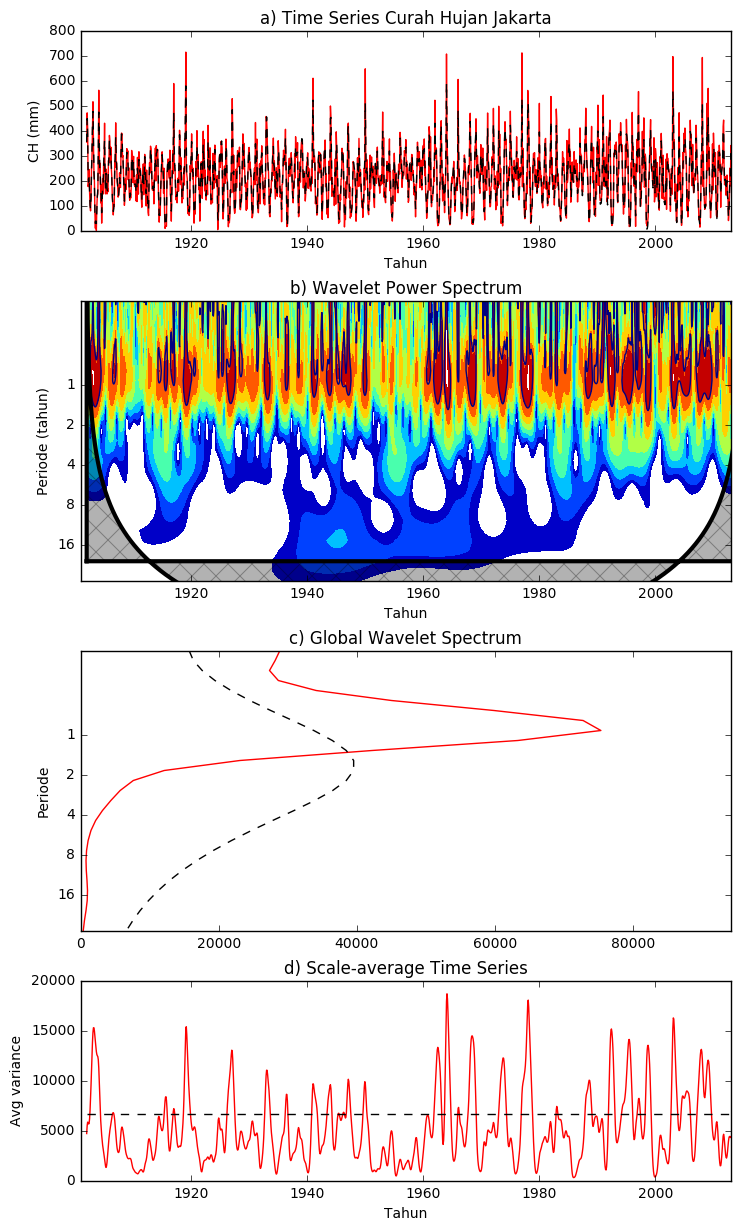

In [72]:
#Plot (nonbiased)
#figure size
fig=plt.figure(figsize=(10,10))

# subplot positions
width= 0.65
hight = 0.28;
pos1a = [0.1, 0.75, width, 0.2]
pos1b = [0.1, 0.4, width, hight]
pos1c = [0.1, 0.05, width, hight]
pos1d = [0.1, -0.2, width, 0.2]

#########################################
#---- a) Original signal
#########################################
ax=fig.add_axes(pos1a)
#original
ax.plot(time,jkt*np.sqrt(variance)+mean,"r-")
#reconstruction
ax.plot(time,iwave*np.sqrt(variance)+mean,"k--")

ax.set_ylabel('CH (mm)')
ax.set_xlabel('Tahun')
plt.title('a) Time Series Curah Hujan Jakarta')

#########################################
#   b) Wavelet spectrum
#########################################

#--- Contour plot wavelet power spectrum
bx=fig.add_axes(pos1b,sharex=ax)
levels = [0.0625,0.125,0.25,0.5,1,2,4,8,16] 
Yticks = 2**(np.arange(np.int(np.log2(np.min(period))),np.int(np.log2(np.max(period)))+1))
bx.contourf(time,np.log2(period),np.log2(powers),np.log2(levels))
bx.set_xlabel('Tahun')
bx.set_ylabel('Periode (tahun)')
import matplotlib.ticker as ticker
ymajorLocator=ticker.FixedLocator(np.log2(Yticks))
bx.yaxis.set_major_locator( ymajorLocator )
ticks=bx.yaxis.set_ticklabels(Yticks)
plt.title('b) Wavelet Power Spectrum')

# 95% significance contour, levels at -99 (fake) and 1 (95% signif)
cs = bx.contour(time,np.log2(period),sig95,[1],color='w',linewidth=1)

# cone-of-influence, anything "below" is dubious
ts = time;
coi_area = np.concatenate([[np.max(scale)], coi, [np.max(scale)],[np.max(scale)]])
ts_area = np.concatenate([[ts[0]], ts, [ts[-1]] ,[ts[0]]]);
L = bx.plot(ts_area,np.log2(coi_area),'k',linewidth=3)
F=bx.fill(ts_area,np.log2(coi_area),'k',alpha=0.3,hatch="x")

#########################################
#   c) Global Wavelet spectrum
#########################################

#--- Plot global wavelet spectrum
cx=fig.add_axes(pos1c,sharey=bx)
cx.plot(global_wss,np.log2(period),"r-")
cx.plot(global_signifs,np.log2(period),'k--')
ylim=cx.set_ylim(np.log2([period.min(),period.max()]))
cx.invert_yaxis()
plt.title('c) Global Wavelet Spectrum')
xrangec=cx.set_xlim([0,1.25*np.max(global_wss)])
cx.set_ylabel('Periode')

#########################################
#   d) Global Wavelet spectrum
#########################################
#--- Plot Scale-averaged spectrum -----------------
dx=fig.add_axes(pos1d,sharex=bx)
dx.plot(time,scale_avgs,"r-")
dx.plot([time[0],time[-1]],[scaleavg_signifs,scaleavg_signifs],"k--")
xrange=dx.set_xlim(xlim)
dx.set_ylabel('Avg variance')
dx.set_xlabel('Tahun')
title=plt.title('d) Scale-average Time Series')


### WAVELET ANALYSIS DENGAN TIPE WAVELET YANG BERBEDA: JAKARTA (DOG)

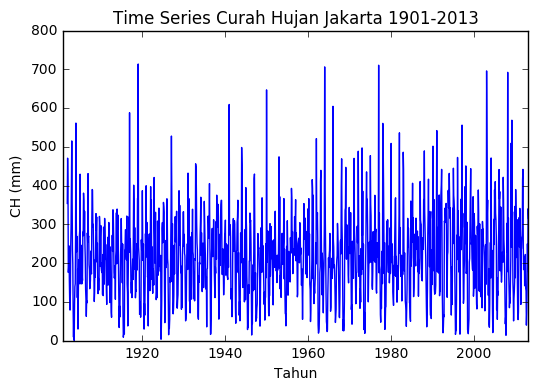

In [73]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from wavelet import wavelet
from wave_signif import wave_signif

jkt=np.fromfile("jakarta.dat", dtype=np.float32)
chjkt = jkt
n=len(jkt)
dt = 1/12

time = np.arange(n)*dt + 1902.0   # construct time array
xlim = [1901,2013]  # plotting range

plt.plot(time,jkt)
plt.xlabel('Tahun')
plt.ylabel('CH (mm)')
plt.title('Time Series Curah Hujan Jakarta 1901-2013')
xrange=plt.xlim(xlim)

In [74]:
variance = np.std(jkt)**2
mean=np.mean(jkt)
jkt = (jkt - np.mean(jkt))/np.sqrt(variance)
print ("mean=",mean)
print ("std=", np.sqrt(variance))

mean= 217.87
std= 110.91607666


In [75]:
pad = 1           # pad the time series with zeroes (recommended)
dj = 0.25         # this will do 4 sub-octaves per octave
s0 = 2.*dt        # this says start at a scale of 6 months
j1 = 7./dj        # this says do 7 powers-of-two with dj sub-octaves each
lag1 = 0.72       # lag-1 autocorrelation for red noise background
mother = 'DOG' # wavelet shape (Morlet, Difference of Gaussian (DOG), Paul)

In [76]:
#Transformasi wavelet
wave,period,scale,coi = wavelet(jkt,dt,pad,dj,s0,j1,mother);
power = (np.abs(wave))**2         # compute wavelet power spectrum

C:\Users\user\Documents\Modul 3 andat\wavelet.py:118: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  temp=np.zeros((2**(base2+1)-n1,))


In [77]:
#Pengaturan Selang Kepercayaan
signif,fft_theor = wave_signif(1.0,dt,scale,0,lag1,-1,-1,mother)
sig95 = np.dot(signif.reshape(len(signif),1),np.ones((1,n))) # expand signif --> (J+1)x(N) array
sig95 = power / sig95         # where ratio > 1, power is significant

In [78]:
#Spektrum Global Wavelet dan Selang Kepercayaan
global_ws = variance*power.sum(axis=1)/float(n)   # time-average over all times
dof = n - scale  # the -scale corrects for padding at edges
global_signif,fft_theor = wave_signif(variance,dt,scale,1,lag1,-1,dof,mother)

In [79]:
#Scale average pada rentang periode 0.5 dan 1.5
avg = (scale >= 0.5) & (scale < 1.5)
Cdelta = 1.132;   # this is for the MORLET wavelet
scale_avg = np.dot(scale.reshape(len(scale),1),np.ones((1,n))) # expand scale --> (J+1)x(N) array
scale_avg = power / scale_avg   # [Eqn(24)]
scale_avg = variance*dj*dt/Cdelta*sum(scale_avg[avg,:])   # [Eqn(24)]
scaleavg_signif ,fft_theor= wave_signif(variance,dt,scale,2,lag1,-1,[2,7.9],mother)

In [80]:
#Penyusunan kembali time series
from wavelet_inverse import wavelet_inverse
iwave=wavelet_inverse(wave, scale, dt, dj, "DOG")
print ("RMSE:",np.sqrt(np.sum((jkt-iwave)**2)/float(len(jkt)))*np.sqrt(variance))

0.867325070584
RMSE: 68.3659146955


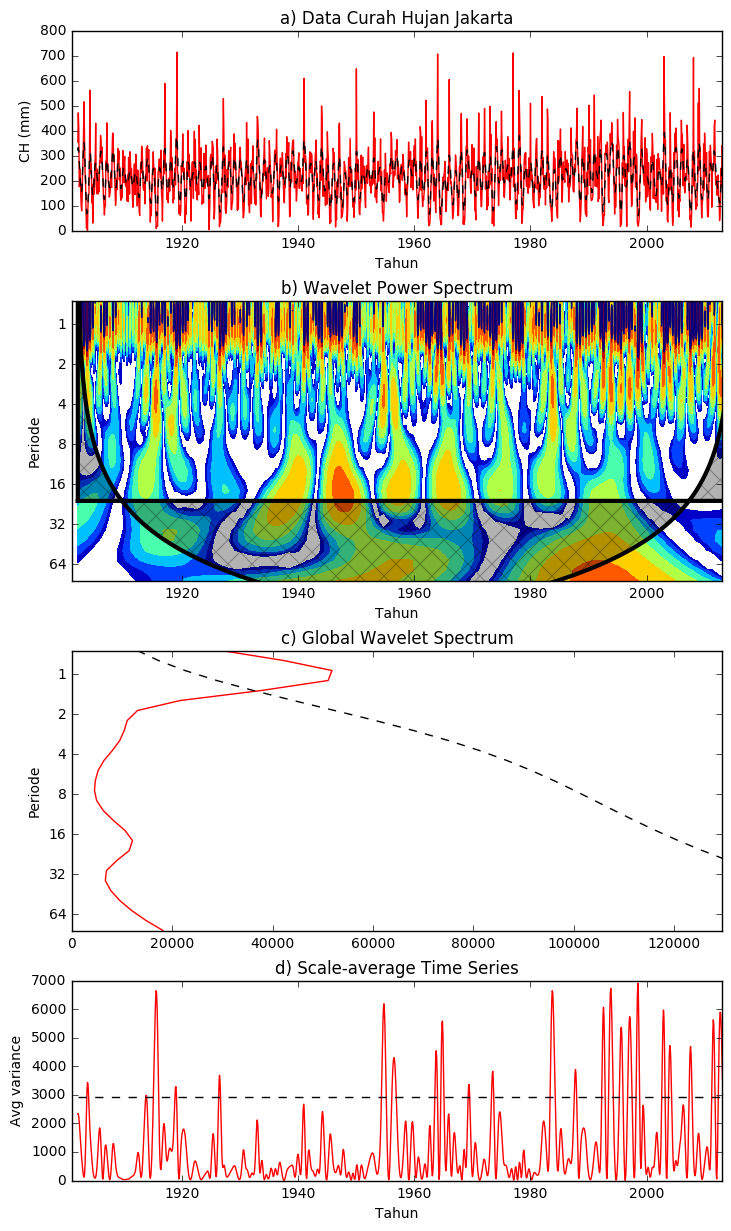

In [81]:
#figure size
fig=plt.figure(figsize=(10,10))

# subplot positions
width= 0.65
hight = 0.28;
pos1a = [0.1, 0.75, width, 0.2]
pos1b = [0.1, 0.4, width, hight]
pos1c = [0.1, 0.05, width, hight]
pos1d = [0.1, -0.2, width, 0.2]

#########################################
#---- a) Original signal
#########################################
ax=fig.add_axes(pos1a)
#original
ax.plot(time,jkt*np.sqrt(variance)+mean,"r-")
#reconstruction
ax.plot(time,iwave*np.sqrt(variance)+mean,"k--")
ax.set_ylabel('CH (mm)')
ax.set_xlabel('Tahun')
plt.title('a) Data Curah Hujan Jakarta')

#########################################
#   b) Wavelet spectrum
#########################################

#--- Contour plot wavelet power spectrum
bx=fig.add_axes(pos1b,sharex=ax)
levels = [0.0625,0.125,0.25,0.5,1,2,4,8,16] 
Yticks = 2**(np.arange(np.int(np.log2(np.min(period))),np.int(np.log2(np.max(period)))+1))
bx.contourf(time,np.log2(period),np.log2(power),np.log2(levels))
bx.set_xlabel('Tahun')
bx.set_ylabel('Periode')
import matplotlib.ticker as ticker
ymajorLocator=ticker.FixedLocator(np.log2(Yticks))
bx.yaxis.set_major_locator( ymajorLocator )
ticks=bx.yaxis.set_ticklabels(Yticks)
plt.title('b) Wavelet Power Spectrum')

# 95% significance contour, levels at -99 (fake) and 1 (95% signif)
cs = bx.contour(time,np.log2(period),sig95,[1],color='k',linewidth=1)

# cone-of-influence, anything "below" is dubious
ts = time;
coi_area = np.concatenate([[np.max(scale)], coi, [np.max(scale)],[np.max(scale)]])
ts_area = np.concatenate([[ts[0]], ts, [ts[-1]] ,[ts[0]]]);
L = bx.plot(ts_area,np.log2(coi_area),'k',linewidth=3)
F=bx.fill(ts_area,np.log2(coi_area),'k',alpha=0.3,hatch="x")

#########################################
#   c) Global Wavelet spectrum
#########################################

#--- Plot global wavelet spectrum
cx=fig.add_axes(pos1c,sharey=bx)
cx.plot(global_ws,np.log2(period),"r-")
cx.plot(global_signif,np.log2(period),'k--')
ylim=cx.set_ylim(np.log2([period.min(),period.max()]))
cx.invert_yaxis()
plt.title('c) Global Wavelet Spectrum')
xrangec=cx.set_xlim([0,1.25*2*np.max(global_ws)])
cx.set_ylabel('Periode')

#########################################
#   d) Scale average Spectrum
#########################################
#--- Plot Scale-averaged spectrum -----------------
dx=fig.add_axes(pos1d,sharex=bx)
dx.plot(time,scale_avg,"r-")
dx.plot([time[0],time[-1]],[scaleavg_signif,scaleavg_signif],"k--")
xrange=dx.set_xlim(xlim)
dx.set_ylabel('Avg variance')
dx.set_xlabel('Tahun')
title=plt.title('d) Scale-average Time Series')

In [82]:
#Pengkoreksian bias
########################
#  Spectrum
########################
powers=np.zeros_like(power)
for k in range(len(scale)):
    powers[k,:] = power[k,:]/scale[k]
#significance: sig95 is already normalized = 1

########################
#  Spectrum
########################
global_wss = global_ws/scale   
global_signifs=global_signif/scale

########################
#  Scale-average between El Nino periods of 2--8 years
########################
# No need to change 
# because in Eqn(24) of Torrence and Compo [1998], division by scale has been done.
scale_avgs=scale_avg
scaleavg_signifs=scaleavg_signif

(0, 6000)

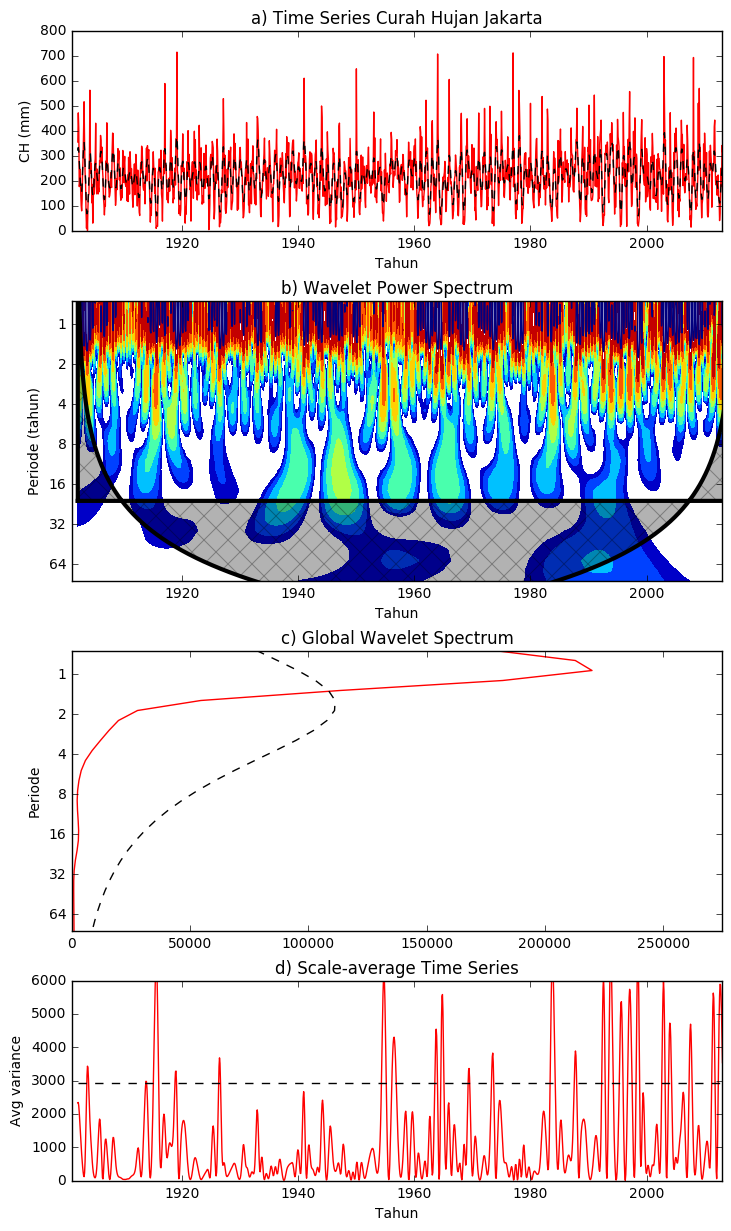

In [83]:
#Plot (nonbiased)
#figure size
fig=plt.figure(figsize=(10,10))

# subplot positions
width= 0.65
hight = 0.28;
pos1a = [0.1, 0.75, width, 0.2]
pos1b = [0.1, 0.4, width, hight]
pos1c = [0.1, 0.05, width, hight]
pos1d = [0.1, -0.2, width, 0.2]

#########################################
#---- a) Original signal
#########################################
ax=fig.add_axes(pos1a)
#original
ax.plot(time,jkt*np.sqrt(variance)+mean,"r-")
#reconstruction
ax.plot(time,iwave*np.sqrt(variance)+mean,"k--")

ax.set_ylabel('CH (mm)')
ax.set_xlabel('Tahun')
plt.title('a) Time Series Curah Hujan Jakarta')

#########################################
#   b) Wavelet spectrum
#########################################

#--- Contour plot wavelet power spectrum
bx=fig.add_axes(pos1b,sharex=ax)
levels = [0.0625,0.125,0.25,0.5,1,2,4,8,16] 
Yticks = 2**(np.arange(np.int(np.log2(np.min(period))),np.int(np.log2(np.max(period)))+1))
bx.contourf(time,np.log2(period),np.log2(powers),np.log2(levels))
bx.set_xlabel('Tahun')
bx.set_ylabel('Periode (tahun)')
import matplotlib.ticker as ticker
ymajorLocator=ticker.FixedLocator(np.log2(Yticks))
bx.yaxis.set_major_locator( ymajorLocator )
ticks=bx.yaxis.set_ticklabels(Yticks)
plt.title('b) Wavelet Power Spectrum')

# 95% significance contour, levels at -99 (fake) and 1 (95% signif)
cs = bx.contour(time,np.log2(period),sig95,[1],color='w',linewidth=1)

# cone-of-influence, anything "below" is dubious
ts = time;
coi_area = np.concatenate([[np.max(scale)], coi, [np.max(scale)],[np.max(scale)]])
ts_area = np.concatenate([[ts[0]], ts, [ts[-1]] ,[ts[0]]]);
L = bx.plot(ts_area,np.log2(coi_area),'k',linewidth=3)
F=bx.fill(ts_area,np.log2(coi_area),'k',alpha=0.3,hatch="x")

#########################################
#   c) Global Wavelet spectrum
#########################################

#--- Plot global wavelet spectrum
cx=fig.add_axes(pos1c,sharey=bx)
cx.plot(global_wss,np.log2(period),"r-")
cx.plot(global_signifs,np.log2(period),'k--')
ylim=cx.set_ylim(np.log2([period.min(),period.max()]))
cx.invert_yaxis()
plt.title('c) Global Wavelet Spectrum')
xrangec=cx.set_xlim([0,1.25*np.max(global_wss)])
cx.set_ylabel('Periode')

#########################################
#   d) Global Wavelet spectrum
#########################################
#--- Plot Scale-averaged spectrum -----------------
dx=fig.add_axes(pos1d,sharex=bx)
dx.plot(time,scale_avgs,"r-")
dx.plot([time[0],time[-1]],[scaleavg_signifs,scaleavg_signifs],"k--")
xrange=dx.set_xlim(xlim)
dx.set_ylabel('Avg variance')
dx.set_xlabel('Tahun')
title=plt.title('d) Scale-average Time Series')
dx.set_ylim([0,6000])

Analisis:

Berdasarkan hasil plot dari tiga tipe wavelate yang berbeda menunjukkan adanya sinyal kuat pada periode 1 tahun. Perbedaan terletak pada representasi variansi rata-rata data. Tipe Morlet dan Paul menunjukkan tingkat variansi rata-rata yang lebih tinggi dibandingkan DOG. Hal ini dikarenakan perbedaan dari fungsi wavelet masing-masing tipe. 


#### III. Kesimpulan

1. Variabilitas curah hujan di Jakarta dan Ambon sangatlah fluktuatif sehingga tipe wavelet yang cocok adalah Morlet dan Paul.

2. Penyebab munculnya sinyal kuat pada periode 1 tahun adalah fenomena Monsun.

3. Pengaruh dari tipe wavelet yang berbeda adalah pada representasi dari variansi data time series curah hujan. Fungsi wavelet kompleks seperti Morlet dan Paul menggambarkan variansi yang lebih baik dan lebih sesuai dengan grafik.




#### DAFTAR PUSTAKA

Torrence, C., Compo, Gilbert P. 1998. A Practical Guide to Wavelet Analysis. Colorado: Program in Atmospheric and Oceanic Sciences University of Colorado. 

http://paos.colorado.edu/research/wavelets/wave_idl/wavelet.pro diakses pada 19 April 2017 pukul 15.35 WIB.

https://id.wikipedia.org/wiki/El_Ni%C3%B1o%E2%80%93Osilasi_Selatan diakses pada 19 April 2017 pukul 17.30 WIB.

http://kamusmeteorology.blogspot.co.id/2012/10/mengenal-monsoon-muson.html diakses pada 20 April 2017 pukul 1:30